<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/Hierarchical_Normal_Model_%26_Gibbs_Sampling_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Overview:**
The dataset consists of annual death counts from five causes for the age group 25–34 over five years (2018–2022). These causes are:

Accidents, Homicide, Suicide, Heart Disease, Malignant Neoplasms
The goal is to model these death counts using three approaches:


*   Separate Gaussian model

*   Pooled Gaussian model
*   Hierarchical Gaussian model

**Why Gibbs Sampling:**
Gibbs sampling is a special case of the Metropolis-Hastings algorithm used for Bayesian inference, particularly when the full conditional distributions of the variables in a model can be easily sampled.

**a. Separate Model:** In a separate model, we treat each group or data source independently. When using Gibbs sampling here, each group's parameters are sampled independently from their respective conditional distributions.



*   **Specific to the model:**  Sample the parameters for each cause of death independently. Each death cause has its own parameters, which could lead to high variability in small samples.


**b. Pooled Model:** In a pooled model, the data from different groups are combined (or "pooled") and treated as if they came from a single distribution. Gibbs sampling in this model would sample the parameters from a single conditional distribution across all data. This reduces variance but may miss group-specific effects, assuming all groups are homogenous.

*   **Specific to the model:**  Pooled Model (Gibbs): Sample from a common parameter for all causes, assuming homogeneity.

**c. Hierarchical Model** (or Partially Pooled Model): In hierarchical models, group-level parameters (for individual groups) are treated as random variables drawn from a higher-level (hyperparameter) distribution. Gibbs sampling here involves sampling both the group-level parameters and the hyperparameters in a conditional step-by-step process. This approach balances between separate and pooled models, allowing group-specific variability while sharing information across groups.

*   **Specific to the model:** Sample group-specific parameters and hyperparameters, allowing for shared information while maintaining some independence between causes.




In [ ]:
!apt-get install -y r-base


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.1-3.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Install the IRkernel package for R support
!R -e "IRkernel::installspec(user = FALSE)"



R version 4.4.1 (2024-06-14) -- "Race for Your Life"
Copyright (C) 2024 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> IRkernel::installspec(user = FALSE)
> 
> 


In [ ]:
# Install dependencies and RStan
install.packages("rstan", repos = "https://cloud.r-project.org/", dependencies=TRUE)

# Load the library
library(rstan)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘lazyeval’, ‘abind’, ‘tensorA’, ‘distributional’, ‘crosstalk’, ‘zoo’, ‘plyr’, ‘igraph’, ‘checkmate’, ‘matrixStats’, ‘posterior’, ‘colourpicker’, ‘DT’, ‘dygraphs’, ‘gtools’, ‘markdown’, ‘reshape2’, ‘shinyjs’, ‘shinythemes’, ‘threejs’, ‘xts’, ‘ggridges’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’, ‘shinystan’, ‘bayesplot’, ‘rstantools’, ‘coda’, ‘V8’


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




**General Setup:**

In [20]:
# Death data for the five causes from 2018 to 2022
deaths <- matrix(c(33058, 34452, 31315, 24516, 24614,   # Accidents
                   6712, 7571, 31315, 5341, 5234,       # Homicide
                   8663, 8862, 8454, 8059, 8020,       # Suicide
                   3789, 4155, 3984, 3495, 3561,       # Heart Disease
                   3641, 3615, 3573, 3577, 3684),      # Malignant Neoplasms
                 ncol = 5, byrow = TRUE)

years <- c(2018, 2019, 2020, 2021, 2022)
n_years <- length(years)
n_causes <- 5


**1. Separate Gaussian Model:** Each cause has its own mean and shared variance

In [24]:
separate_model_code <- "
data {
  int<lower=0> N;   // number of years
  int<lower=0> C;   // number of causes
  matrix[N, C] y;   // data for deaths
}
parameters {
  vector[C] mu;     // mean for each cause
  real<lower=0> sigma;   // common standard deviation
}
model {
  for (n in 1:N) {
    for (c in 1:C) {
      y[n, c] ~ normal(mu[c], sigma);  // Separate normal distribution for each cause
    }
  }
}
generated quantities {
  real mu_post[C];
  real y_pred[C];

  // Posterior mean of the causes
  for (c in 1:C)
    mu_post[c] = mu[c];

  // Predictive distribution for a hypothetical 6th cause
  for (c in 1:C)
    y_pred[c] = normal_rng(mu[c], sigma);
}
"


# Prepare data for Stan
separate_data <- list(N = n_years, C = n_causes, y = deaths)

# Fit the model using Stan
separate_fit <- stan(model_code = separate_model_code, data = separate_data,
                     iter = 2000, chains = 4)

# Extract results
print(separate_fit)




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.442 seconds (Warm-up)
Chain 1:                0.042 seconds (Sampling)
Chain 1:                0.48

In [25]:
# Gibbs sampling for the separate Gaussian model

# Data
deaths <- matrix(c(33058, 34452, 31315, 24516, 24614,   # Accidents
                   6712, 7571, 31315, 5341, 5234,       # Homicide
                   8663, 8862, 8454, 8059, 8020,       # Suicide
                   3789, 4155, 3984, 3495, 3561,       # Heart Disease
                   3641, 3615, 3573, 3577, 3684),      # Malignant Neoplasms
                 ncol = 5, byrow = TRUE)
n_years <- nrow(deaths)
n_causes <- ncol(deaths)

# Hyperparameters
mu_prior_mean <- 0
mu_prior_variance <- 100^2  # Weak prior
alpha <- 0.001
beta <- 0.001

# Initialize parameters
mu <- apply(deaths, 2, mean)  # Start with the sample mean for each cause
sigma2 <- 1000  # Start with a large initial variance

# Gibbs sampling settings
n_iter <- 2000
mu_samples <- matrix(NA, nrow = n_iter, ncol = n_causes)
sigma2_samples <- numeric(n_iter)

# Gibbs sampling loop
for (iter in 1:n_iter) {
  # Sample each mu_c | sigma^2, y
  for (c in 1:n_causes) {
    y_c <- deaths[, c]
    n <- length(y_c)
    mu_post_mean <- (sum(y_c) / sigma2 + mu_prior_mean / mu_prior_variance) /
                    (n / sigma2 + 1 / mu_prior_variance)
    mu_post_var <- 1 / (n / sigma2 + 1 / mu_prior_variance)
    mu[c] <- rnorm(1, mean = mu_post_mean, sd = sqrt(mu_post_var))
  }

  # Sample sigma^2 | mu, y
  residuals <- deaths - matrix(rep(mu, each = n_years), n_years, n_causes)
  ss <- sum(residuals^2)
  sigma2_post_shape <- alpha + 0.5 * n_years * n_causes
  sigma2_post_rate <- beta + 0.5 * ss
  sigma2 <- 1 / rgamma(1, shape = sigma2_post_shape, rate = sigma2_post_rate)

  # Store the samples
  mu_samples[iter, ] <- mu
  sigma2_samples[iter] <- sigma2
}

# Results
mu_samples_mean <- apply(mu_samples, 2, mean)
sigma2_mean <- mean(sigma2_samples)

print("Posterior means of mu for each cause:")
print(mu_samples_mean)

print("Posterior mean of sigma^2:")
print(sigma2_mean)


[1] "Posterior means of mu for each cause:"
[1]  9.575408  9.877249 12.709542  6.546121  6.945206
[1] "Posterior mean of sigma^2:"
[1] 264213076


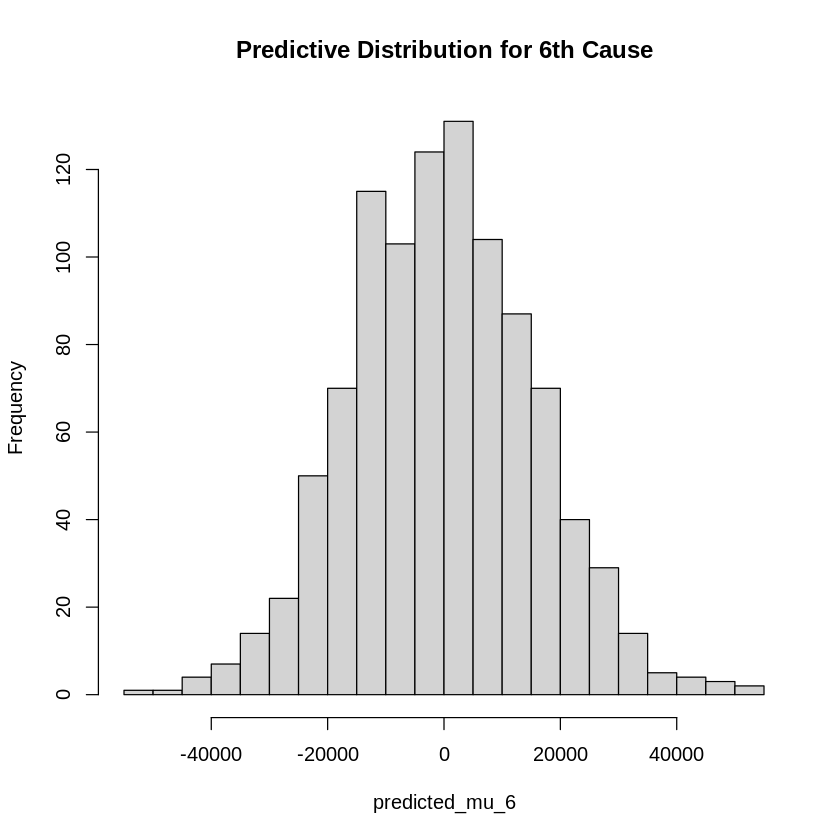

In [17]:
# Extract posterior samples of mu and sigma
post_samples <- extract(fit_separate)
mu_samples <- post_samples$mu
sigma_samples <- post_samples$sigma

# Predict the 6th cause
predicted_mu_6 <- rnorm(1000, mean = mean(mu_samples), sd = mean(sigma_samples))
hist(predicted_mu_6, breaks = 30, main = "Predictive Distribution for 6th Cause")


In [19]:
gibbs_separate <- function(y, num_samples, burn_in) {
  N <- nrow(y)
  C <- ncol(y)

  # Initialize storage for samples
  samples_mu <- matrix(NA, nrow = num_samples, ncol = C)
  samples_sigma <- numeric(num_samples)

  # Set initial values
  samples_mu[1, ] <- colMeans(y)
  samples_sigma[1] <- sd(as.numeric(y))

  # Gibbs sampling
  for (i in 2:num_samples) {
    # Sample mu_i for each cause from Normal
    for (j in 1:C) {
      mu_post_mean <- mean(y[, j])
      mu_post_sd <- samples_sigma[i-1] / sqrt(N)
      samples_mu[i, j] <- rnorm(1, mu_post_mean, mu_post_sd)
    }

    # Sample sigma from the posterior (Inverse-Gamma)
    residuals <- y - matrix(samples_mu[i, ], nrow = N, ncol = C, byrow = TRUE)
    sigma_post_shape <- (N * C) / 2
    sigma_post_scale <- sum(residuals^2) / 2
    samples_sigma[i] <- sqrt(1 / rgamma(1, sigma_post_shape, sigma_post_scale))
  }

  # Discard burn-in samples
  samples_mu <- samples_mu[(burn_in + 1):num_samples, ]
  samples_sigma <- samples_sigma[(burn_in + 1):num_samples]

  return(list(mu = samples_mu, sigma = samples_sigma))
}

# Run Gibbs Sampling for Separate Gaussian Model
set.seed(123)
num_samples <- 10000
burn_in <- 1000
separate_results <- gibbs_separate(y = data_list$y, num_samples = num_samples, burn_in = burn_in)

# Posterior distributions for means of 5 causes
separate_results$mu  # Posterior samples for each mu_i

# Predictive distribution for a 6th cause
# In the separate model, the 6th cause would not share any structure with the other causes
mu_6_samples_separate <- rnorm(1000, mean = mean(separate_results$mu), sd = mean(separate_results$sigma))


19185.980,17436.0806,23497.619,3740.1184,19315.019
16995.633,5639.2873,15385.758,9945.3480,2133.869
14248.832,5750.9795,5584.717,7566.1320,11780.936
3899.205,14848.9441,13156.048,4661.5249,6511.623
11027.535,2611.8800,11463.993,1734.0963,24030.843
12360.153,487.1615,10425.785,-2888.7357,2041.770
6342.027,15558.9181,10388.534,-909.3598,14299.753
2416.655,7933.5814,20321.028,3615.6042,13203.481
11284.580,18009.5295,16381.460,13588.3654,18754.314
11843.155,19836.5494,25763.163,19719.1495,1348.076
15038.816,25522.9500,4695.606,20645.7648,14522.471
